<h1><center> 来自SEC数据的ESG得分-Nucleus API实例</center></h1>


<h1><center>  所有权及保密条款属SumUp Analytics所有</center></h1>
<h1><center>  免责声明和服务条款可通过 www.sumup.ai 获取</center></h1>


#  

 


## 目标:
-	Develop a proprietary ESG scoring methodology


## 数据:
-	A chosen list of corporations (e.g. within the same industry sector, or with similar market capitalization)
 - 	Company reports such as SEC filings
 - 	Press releases
 - 	Earning call transcripts



## Nucleus APIs:
-	数据集创建 API
 - 	*api_instance.post_upload_file(file, dataset)*
 - 	*nucleus_helper.import_files(api_instance, dataset, file_iters, processes=1)*

        nucleus_helper.import_files利用api_instance.post_upload_file并行执行来加速数据集的创建


-	主题建模 API
 - 	*api_instance.post_topic_api(payload)*


-	主题情绪  API
 - 	*api_instance.post_topic_sentiment_api(payload)*


-	DocInfo API
 - 	*api_instance.post_doc_info(payload)*


-	DatasetInfo API
 - 	*api_instance.post_dataset_info(payload)*


## 方法:

### 1.	数据集准备
-	创建一个Nucleus数据集，其中包含所选历史时期内的所有相关文档
-   利用Nucleus提供的公司文件提要
-   We will focus on the IT sector for this example
    

In [1]:
import csv
import json
import datetime
import regex as re
import numpy as np
import nucleus_api.api.nucleus_api as nucleus_helper
import nucleus_api
from nucleus_api.rest import ApiException

configuration = nucleus_api.Configuration()
configuration.host = 'UPDATE-WITH-API-SERVER-HOSTNAME'
configuration.api_key['x-api-key'] = 'UPDATE-WITH-API-KEY'
# 创建API实例
api_instance = nucleus_api.NucleusApi(nucleus_api.ApiClient(configuration))

In [ ]:
dataset = "Corporate_docs" 
period_start = "2015-01-01" 
period_end= "2019-06-01"
tickers = ['AAPL','MSFT','INTC','CSCO','MA','ORCL','IBM','CRM','PYPL','ACN US','ADBE','TXN','NVDA','INTU','QCOM','ADSK','CTSH','XLNX','HPQ','SPLK','TEL US','HPE','FISV','AMD','LRCX','MCHP','DXC','NOW','SYMC','ON','CDW','AKAM','FIS','NTAP','MXIM','DELL','ADS','VRSN','JNPR','LDOS','ANET','TER','GPN','TSS','IT','GDDY','CTXS','FTNT','DATA','ZBRA','WU','TYL','PAYC','CGNX','DOX']

payload = nucleus_api.EdgarQuery(destination_dataset=dataset,
                                tickers=tickers, 
                                filing_types=["10-K", "10-K/A", "10-Q", "10-Q/A", "8-K", "8-K/A"], 
                                sections=[],
                                period_start=period_start,
                                period_end=period_end)

api_response = api_instance.post_create_dataset_from_sec_filings(payload)

**您可以随后直接在API中处理数据集中的特定时间段，如下所示**

### 2. 定义ESG查询以关注内容分析

In [3]:
query_E = "Biodiversity OR Carbon OR Cleantech OR Clean OR Climate OR Coal OR Conservation OR Ecosystem OR Emission OR Energy OR Fuel OR Green OR Land OR Natural OR Pollution OR (Raw AND materials) OR Renewable OR Resources OR Sustainability OR Sustainable OR Toxic OR Waste OR Water"

query_S = "Accident OR (Adult AND entertainment) OR Alcohol OR Anti-personnel OR Behavior OR Charity OR (Child AND Labor) OR Community OR Controversial OR Controversy OR Discrimination OR Gambling OR Health OR Human capital OR Human rights OR Inclusion OR Injury OR Labor OR Munitions OR Opposition OR Pay OR Philanthropic OR Quality OR Responsible"

query_G = "Advocacy OR Bribery OR Compensation OR Competitive OR Corruption OR (Data AND breach) OR Divestment OR Fraud OR (Global AND Compact) OR GRI OR (Global AND Reporting AND Initiative) OR Independent OR Justice OR Stability OR Stewardship OR Transparency"

### 3.	在每个ESG主题上排名公司
- 在3个ESG主题中的每个主题上的给定时间点提取关键主题


- 衡量每个主题的情绪，将所有关键主题分类为“好”和“坏”主题


- 确定每个公司对每个主题的曝光度


- 根据主题的“好”或“坏”性质，将特定公司的风险总结在关键主题上，以得出公司的排名
 - 顶级公司是最能接触到好主题和/或最少接触到不良主题的公司
 
 
- 接下来，我们将讨论如何通过利用不同参数来优化此分析




In [ ]:
# 确定哪些公司与主题相关的文档相关联
company_list = tickers


print('-------- Get topic sentiment and exposure per firm ----------------')

payload = nucleus_api.TopicSentimentModel(dataset='Corporate_docs',          
                                query=query_E,                   
                                num_topics=8,
                                num_keywords=8,
                                period_start = "2017-01-01", 
                                period_end= "2017-03-01")
try:
    api_response = api_instance.post_topic_sentiment_api(payload)    
    api_ok = True
except ApiException as e:
    api_error = json.loads(e.body)
    print('ERROR:', api_error['message'])
    api_ok = False

if api_ok:
    company_rankings = np.zeros([len(company_list), len(api_response.result)])
    for i, res in enumerate(api_response.result):
        print('Topic', i, 'sentiment:')
        print('    Keywords:', res.keywords)

        # 使用数据集元数据将主题中的所有文档曝光聚合到公司曝光中
        payload = nucleus_api.DocInfo(dataset='Corporate_docs', doc_ids = res.doc_ids)
        try:
            api_response1 = api_instance.post_doc_info(payload)
            api_ok = True
        except ApiException as e:
            api_error = json.loads(e.body)
            print('ERROR:', api_error['message'])
            api_ok = False

        if api_ok:
            company_sources = [] # 此列表可能比整个数据集短，因为并非所有公司都必须对特定主题做出贡献
            for res1 in api_response1.result:        
                company_sources.append(re.split("\s",res1.attribute['filename'])[0]) 

            company_contributions = np.zeros([len(company_list), 1])
            for j in range(len(company_list)):
                for k in range(len(company_sources)):
                    if company_sources[k] == company_list[j]:
                        company_contributions[j] += json.loads(res.doc_topic_exposures[0])[k]

            company_rankings[:, i] = [x[0] for x in  float(res.strength) * float(res.sentiment) * company_contributions[:]]   

            print('---------------')


    # 将每个主题的公司排名添加到当前分析的主题（E，S，G）的最终ESG分数中
    ESG_score = np.mean(company_rankings, axis=1)

-	对历史时段中的每个日期重复上述任务，以获得ESG分数的完整历史记录

-   更改使用的查询：query_E，query_S，query_G以获得每个公司在3个可持续发展支柱中的每一个的得分

In [10]:
print('------------ Retrieve all companies found in the dataset ----------')
import datetime
company_list = tickers


print('--------------- Retrieve the time range of the dataset -------------')

payload = nucleus_api.DatasetInfo(dataset='Corporate_docs', query='')
api_response = api_instance.post_dataset_info(payload)

first_date = datetime.datetime.fromtimestamp(float(api_response.result.time_range[0]))
last_date = datetime.datetime.fromtimestamp(float(api_response.result.time_range[1]))
delta = last_date - first_date

# 遍历时间和每个日期，计算公司的排名
T = 180 # 回顾期以天为单位

ESG_score2 = []
for i in range(delta.days):  
    if i == 0:
        end_date = first_date + datetime.timedelta(days=T)
 
    # 用于T天回溯期的第一个和最后一个日期
    start_date = end_date - datetime.timedelta(days=T)
    start_date_str = start_date.strftime("%Y-%m-%d 00:00:00")

    # 一个每日指标
    end_date = end_date + datetime.timedelta(days=1) 
    end_date_str = end_date.strftime("%Y-%m-%d 00:00:00")
    try: 
        payload = nucleus_api.TopicSentimentModel(dataset="Corporate_docs",      
                                    query=query_E,                   
                                    num_topics=8,
                                    num_keywords=8,
                                    period_start=start_date_str,
                                    period_end=end_date_str)
        api_response = api_instance.post_topic_sentiment_api(payload)

        company_rankings = np.zeros([len(company_list), len(api_response.result)])
        for l, res in enumerate(api_response.result):
            # 使用数据集元数据将主题中的所有文档曝光聚合到公司曝光中
            payload = nucleus_api.DocInfo(dataset='Corporate_docs', doc_ids=res.doc_ids)
            api_response1 = api_instance.post_doc_info(payload)

            company_sources = [] # 此列表将比整个数据集短得多，因为并非所有文档都对特定主题有贡献
            for res1 in api_response1.result:        
                company_sources.append(re.split('\s',res1.attribute['filename'])[0]) 

            company_contributions = np.zeros([len(company_list), 1])
            for j in range(len(company_list)):
                for k in range(len(company_sources)):
                    if company_sources[k] == company_list[j]:
                        company_contributions[j] += json.loads(res.doc_topic_exposures[0])[k]

            company_rankings[:, l] = [x[0] for x in  float(res.strength) * float(res.sentiment) * company_contributions[:]]      

        # 将每个主题的公司排名添加到当前分析的主题（E，S，G）的最终ESG分数中
        ESG_score2.append(np.mean(company_rankings, axis=1))
    except:
        ESG_score2.append(ESG_score2[-1])

------------ Retrieve all companies found in the dataset ----------
--------------- Retrieve the time range of the dataset -------------


### 3.	结果解释
-	绘制公司ESG得分的时间序列

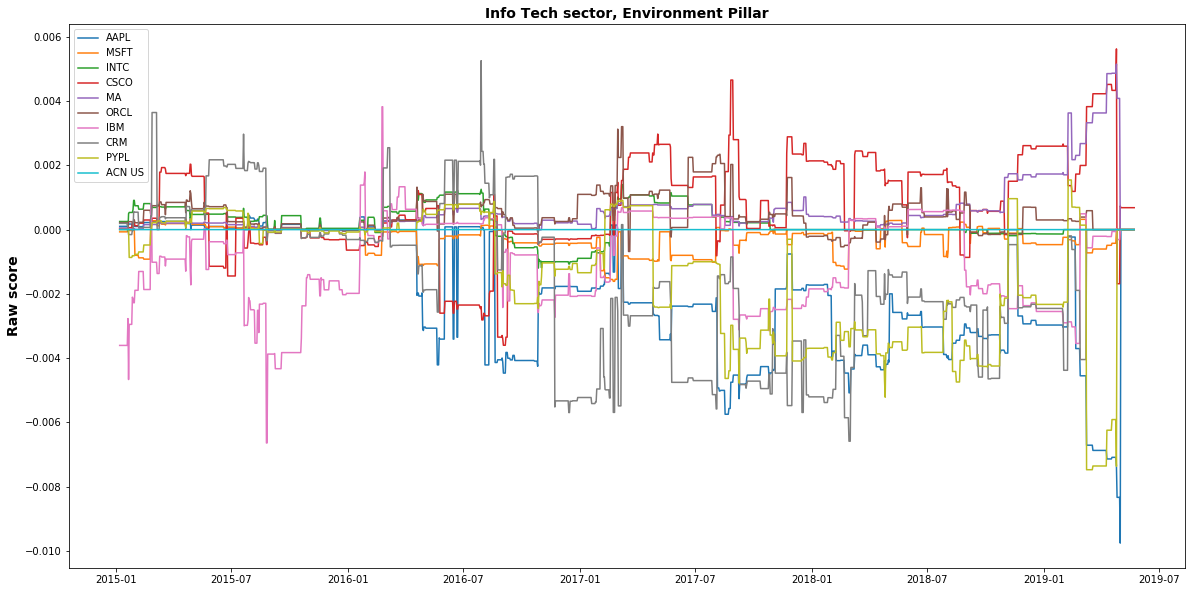

In [7]:
import datetime
time_stamps = [first_date + i * datetime.timedelta(days=1) for i in range(delta.days)]

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(time_stamps, ESG_score) 
#plt.xticks(time_stamps, rotation='vertical')

labels = tickers
plt.legend(labels)
plt.ylabel('Raw score', fontsize=14, fontweight="bold")        
plt.title("Info Tech sector, Environment Pillar", fontsize=14, fontweight="bold")
plt.show() 

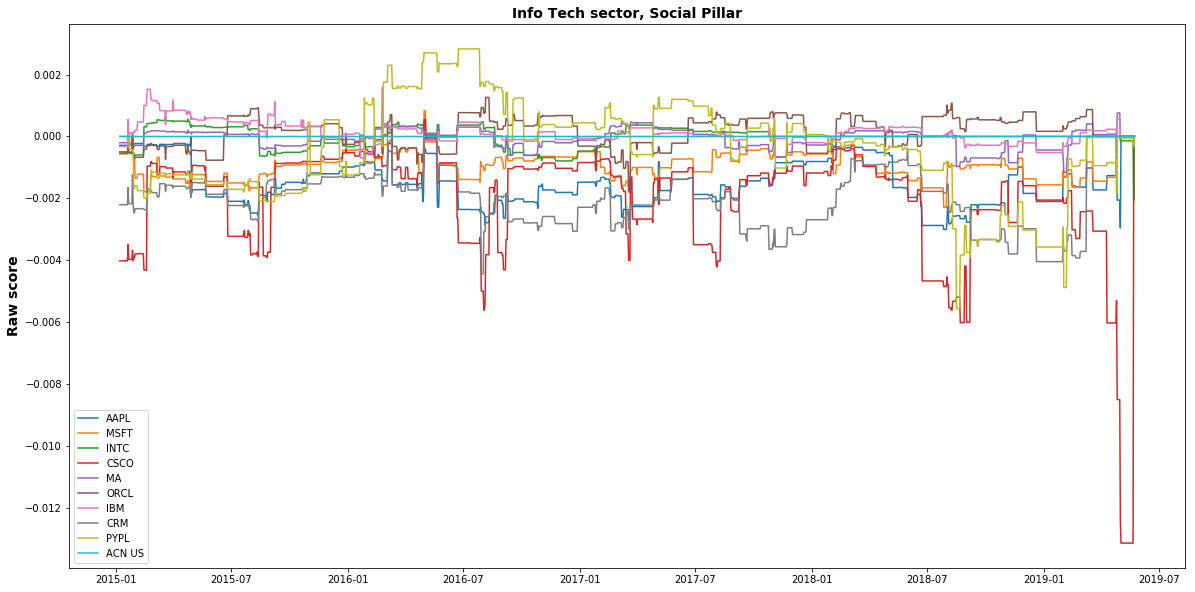

In [9]:
plt.figure(figsize=(20,10))
plt.plot(time_stamps, ESG_score1) 
#plt.xticks(time_stamps, rotation='vertical')

labels = tickers
plt.legend(labels)
plt.ylabel('Raw score', fontsize=14, fontweight="bold")        
plt.title("Info Tech sector, Social Pillar", fontsize=14, fontweight="bold")
plt.show() 

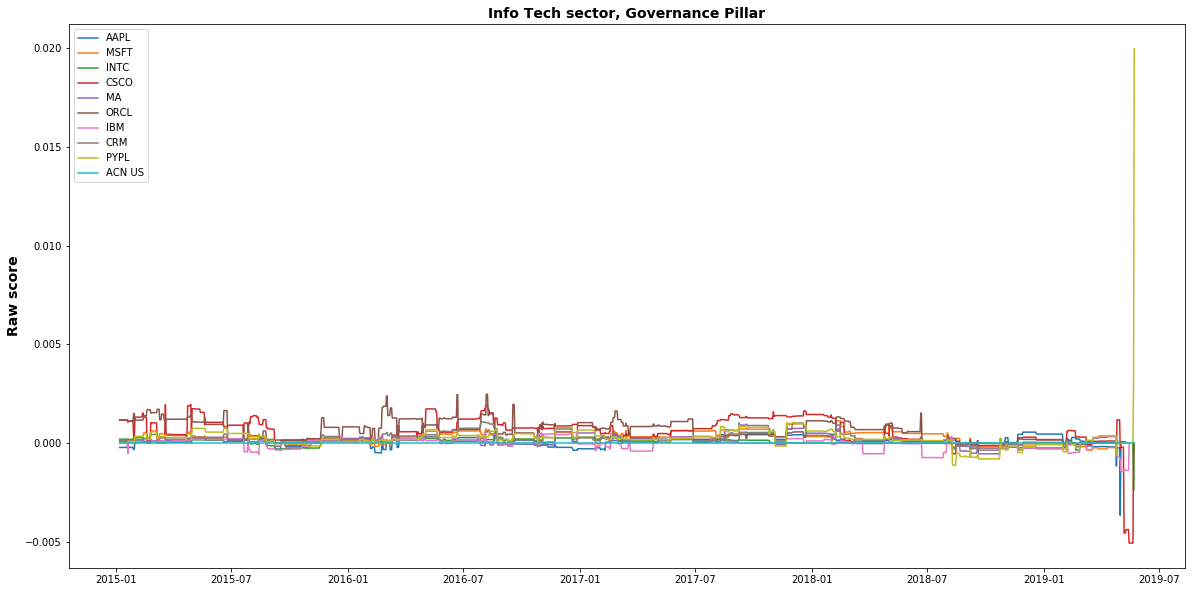

In [12]:
plt.figure(figsize=(20,10))
plt.plot(time_stamps, ESG_score2) 
#plt.xticks(time_stamps, rotation='vertical')

labels = tickers
plt.legend(labels)
plt.ylabel('Raw score', fontsize=14, fontweight="bold")        
plt.title("Info Tech sector, Governance Pillar", fontsize=14, fontweight="bold")
plt.show() 

In [23]:
ESG_combined = []
for i in range(len(ESG_score1)):
    ESG_combined.append(ESG_score[i] + ESG_score1[i] + ESG_score2[i])

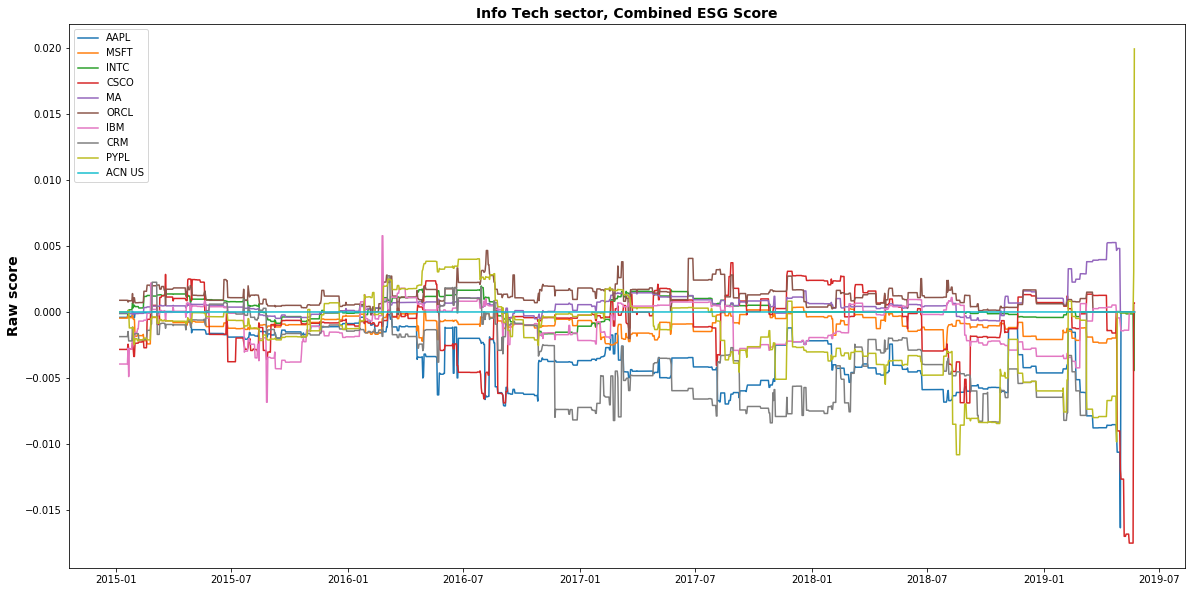

In [24]:
plt.figure(figsize=(20,10))
plt.plot(time_stamps, ESG_combined) 
#plt.xticks(time_stamps, rotation='vertical')

labels = tickers
plt.legend(labels)
plt.ylabel('Raw score', fontsize=14, fontweight="bold")        
plt.title("Info Tech sector, Combined ESG Score", fontsize=14, fontweight="bold")
plt.show() 

### 4.	微调

#### a.	量身定制主题
-   使用Topic Sentiment API中的`custom stop_words`参数排除不相关或次要主题以定制单个名称屏幕


-	提取文档子集（E，S，G）的关键主题并打印相应的关键字




In [ ]:
print('------------- Get list of topics from dataset --------------')

payload = nucleus_api.Topics(dataset='Corporate_docs',                       
                                query=query_E,                       
                                num_topics=20, 
                                num_keywords=8,
                                period_start="2015-01-01",
                                period_end="2019-06-01")
try:
    api_response = api_instance.post_topic_api(payload)        
    api_ok = True
except ApiException as e:
    api_error = json.loads(e.body)
    print('ERROR:', api_error['message'])
    api_ok = False

if api_ok:    
    for i, res in enumerate(api_response.result.topics):
        print('Topic', i, ' keywords: ', res.keywords)    
        print('---------------')

然后，您可以通过创建custom_stop_words变量来定制评分分析。 例如，将如下所示的初始化变量传递到第2节主代码的有效负载中：

In [ ]:
custom_stop_words = ["call","report"] # str | List of stop words. (optional)

#### b.	探索文档类型，回顾期，提取的主题数量的影响
**num_topics**: 您可以通过更改第2部分主要代码中有效负载中的变量`num_topics`，使用不同广度的主题来计算公司的ESG分数。
- 较大的值将在确定分数时包含更广泛的主题，而较小的值将提供密度较集中的主题。
- 如果`num_topics`太大，一些非常边缘的话题可能会在测量公司ESG分数时带来很多噪音。


**T**: 您可以通过更改第2节主要代码中的变量`T`（lookback）来计算公司的不同传播速度的ESG得分。
- 如果T太小，将只使用很少的文件，这可能会导致评分公司产生很多噪音。
- 如果T太大，由于平滑效果，排名的响应性会降低。


**Document types**: 您可以通过使用较少类型的文件重建数据集来调查公司的ESG分数如何随特定类型的公司归档而变化：



In [ ]:
payload = nucleus_api.EdgarQuery(destination_dataset=dataset,
                                tickers=tickers, 
                                filing_types=["10-Q", "10-Q/A"], 
                                sections=[],
                                period_start=period_start,
                                period_end=period_end)

api_response = api_instance.post_create_dataset_from_sec_filings(payload)

### 5.	下一步
-	可能的扩展：针对不同的行业部门重复上述任务

-	可能的扩展：将原始ESG分数转换为标准化度量

        $$Score(Company_i) = \frac {Rank(Company_i)–Average(Ranks,[Companies])} {Std(Ranks, [Companies])}$$

版权(c) 2019年 SumUp Analytics 公司 版权所有。

通知：所有信息均属于Sumup Analytics Inc公司及其供应商的财产。 本合同所包含的知识产权和技术概念属于Sumut Analytics Inc.及其供应商的专利，可由美国和外国专利、在工艺中的专利以及受贸易秘密或版权法保护的专利涵盖。

除非得到Sumup Analytics公司的事先书面批准，否则严禁传播此类信息或复制此材料。